<a href="https://colab.research.google.com/github/RP335/gnn_demo/blob/main/gnn_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkx

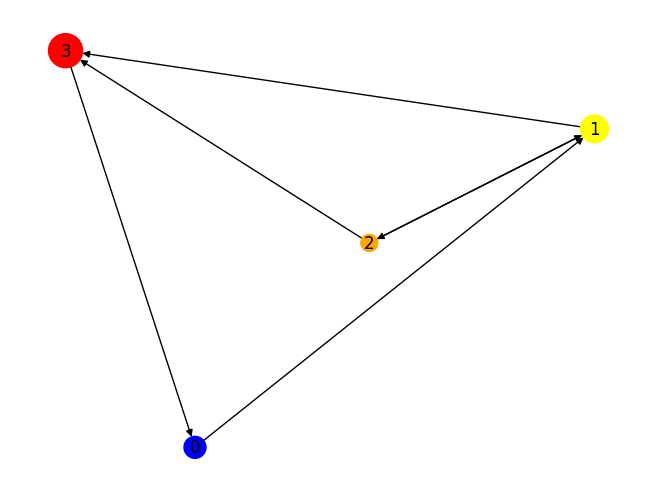

In [ ]:
import networkx as nx
H = nx.DiGraph()
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])

H.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 0),
    (2,1),
    (1,3)
])

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

#Plotting Graph
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

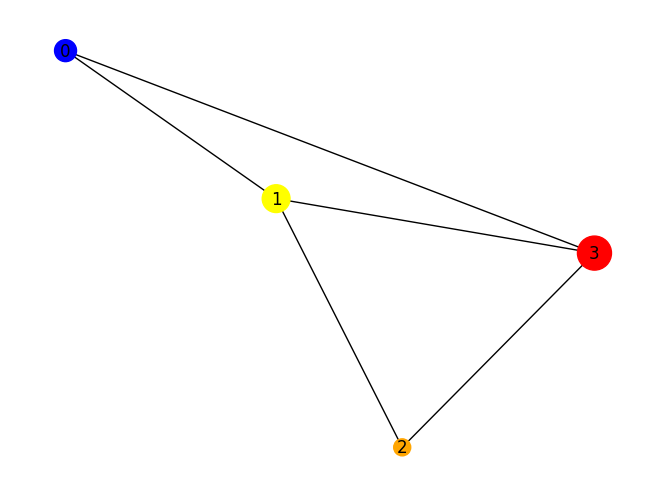

In [ ]:
#converting to undirected graph
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [ ]:
!pip install -q torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.9 MB/s eta 0:00:00


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=507268 sha256=ff82c4904db18af2811d492407dff35771cd7231fe5b97ffe35999137c9439e7
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1092566 sha256=b8b4500838e51e16e6b2882572deec52fdcb2946965d4b42502f3d3ed0eca527
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
  Cloning h

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)
print(data.x)
print(data.y)


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 4, 4,  ..., 3, 3, 3])


Done!


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GCN(hidden_channels=16)
print(model)
print(data)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


[[-53.68861    -1.3133905]
 [-18.753067   -5.241291 ]
 [ -2.0592687  -9.450201 ]
 ...
 [ 43.131485  -35.700935 ]
 [ 27.884697   12.164233 ]
 [ 28.428293   12.369654 ]]


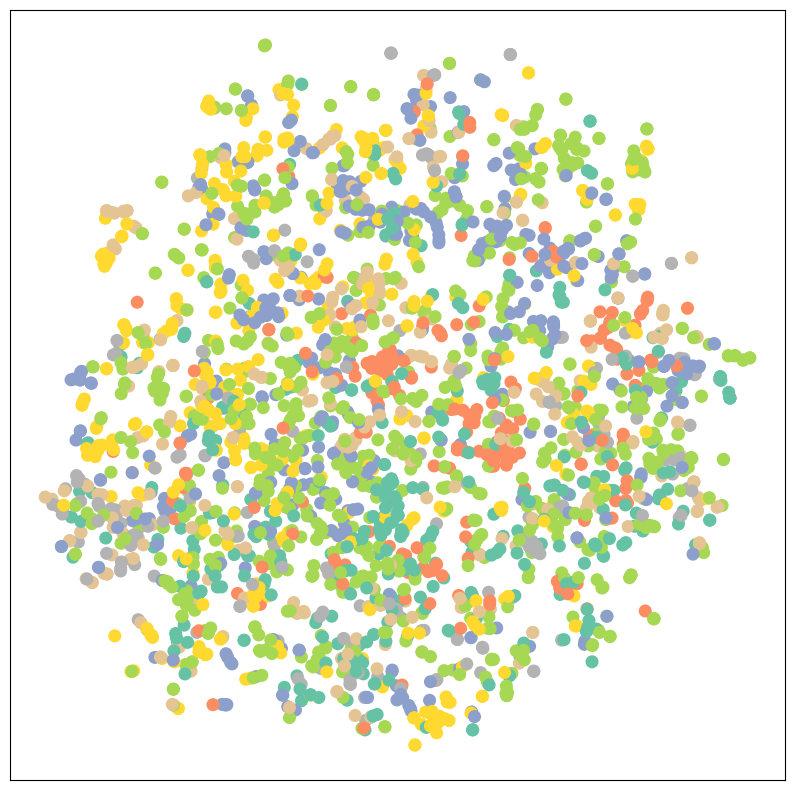

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    print(z)
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Epoch: 001, Loss: 1.9454
Epoch: 002, Loss: 1.9403
Epoch: 003, Loss: 1.9323
Epoch: 004, Loss: 1.9259
Epoch: 005, Loss: 1.9154
Epoch: 006, Loss: 1.9103
Epoch: 007, Loss: 1.8994
Epoch: 008, Loss: 1.8873
Epoch: 009, Loss: 1.8813
Epoch: 010, Loss: 1.8710
Epoch: 011, Loss: 1.8545
Epoch: 012, Loss: 1.8486
Epoch: 013, Loss: 1.8228
Epoch: 014, Loss: 1.8070
Epoch: 015, Loss: 1.8072
Epoch: 016, Loss: 1.7904
Epoch: 017, Loss: 1.7772
Epoch: 018, Loss: 1.7533
Epoch: 019, Loss: 1.7512
Epoch: 020, Loss: 1.7137
Epoch: 021, Loss: 1.7032
Epoch: 022, Loss: 1.6899
Epoch: 023, Loss: 1.6721
Epoch: 024, Loss: 1.6349
Epoch: 025, Loss: 1.6515
Epoch: 026, Loss: 1.6212
Epoch: 027, Loss: 1.6031
Epoch: 028, Loss: 1.5705
Epoch: 029, Loss: 1.5633
Epoch: 030, Loss: 1.5426
Epoch: 031, Loss: 1.5058
Epoch: 032, Loss: 1.4858
Epoch: 033, Loss: 1.4793
Epoch: 034, Loss: 1.4661
Epoch: 035, Loss: 1.4338
Epoch: 036, Loss: 1.4176
Epoch: 037, Loss: 1.4124
Epoch: 038, Loss: 1.3769
Epoch: 039, Loss: 1.3293
Epoch: 040, Loss: 1.3055


[[  9.05155   52.649017]
 [ 58.483585 -17.926287]
 [ 52.419437 -15.74362 ]
 ...
 [-20.697128  -3.498441]
 [ 11.141502  37.08431 ]
 [  6.852683  36.210495]]


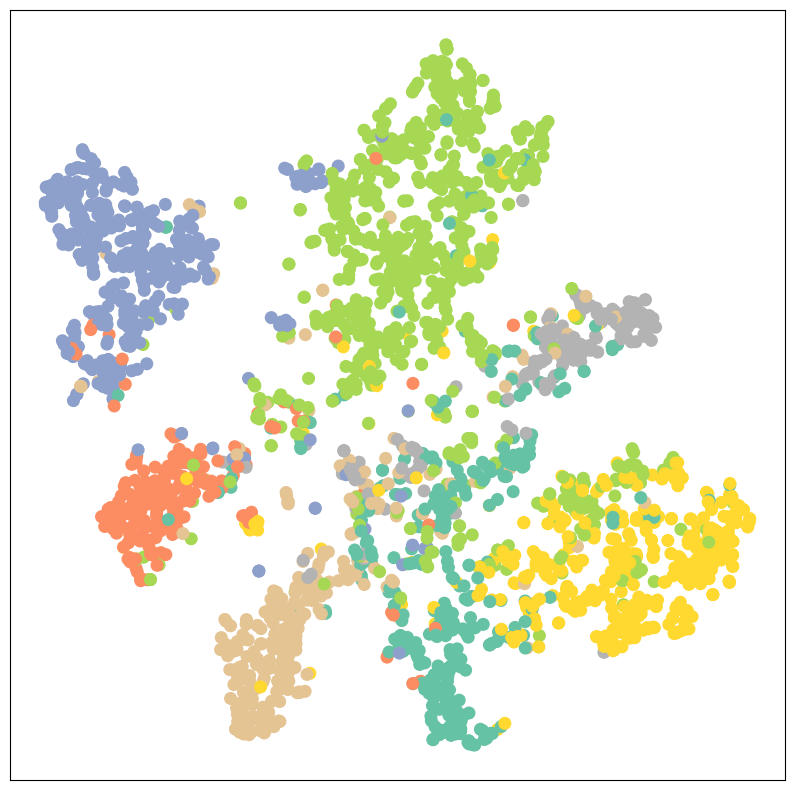

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATv2Conv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):

        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model2 = GAT(hidden_channels=8, heads=8)
print(model2)

optimizer = torch.optim.Adam(model2.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()



def train():
      model2.train()
      optimizer.zero_grad()
      out = model2(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss


def test(mask):
      model.eval()
      out = model2(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')




GAT(
  (conv1): GATv2Conv(1433, 8, heads=8)
  (conv2): GATv2Conv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0285, Val: 0.1080, Test: 0.1000
Epoch: 002, Loss: 3.9713, Val: 0.1160, Test: 0.1040
Epoch: 003, Loss: 3.9152, Val: 0.1200, Test: 0.1070
Epoch: 004, Loss: 3.8534, Val: 0.1340, Test: 0.1110
Epoch: 005, Loss: 3.7821, Val: 0.1220, Test: 0.1290
Epoch: 006, Loss: 3.7030, Val: 0.1300, Test: 0.1320
Epoch: 007, Loss: 3.6125, Val: 0.1340, Test: 0.1300
Epoch: 008, Loss: 3.5189, Val: 0.1720, Test: 0.1350
Epoch: 009, Loss: 3.3996, Val: 0.1560, Test: 0.1670
Epoch: 010, Loss: 3.2904, Val: 0.1800, Test: 0.1690
Epoch: 011, Loss: 3.1756, Val: 0.1620, Test: 0.1820
Epoch: 012, Loss: 3.0306, Val: 0.1780, Test: 0.1930
Epoch: 013, Loss: 2.9175, Val: 0.2100, Test: 0.2360
Epoch: 014, Loss: 2.7730, Val: 0.2280, Test: 0.2370
Epoch: 015, Loss: 2.6349, Val: 0.2480, Test: 0.2450
Epoch: 016, Loss: 2.4914, Val: 0.2140, Test: 0.2690
Epoch: 017, Loss: 2.3809, Val: 0.2400, Test: 0.2710
Epoch: 018, Loss: 2.2912, Val: 0.

[[ 36.596317  14.775197]
 [ 11.057809  61.104572]
 [ 15.582772  50.696434]
 ...
 [-16.88135  -21.636847]
 [ 25.212175  17.479132]
 [ 24.987307  17.265741]]


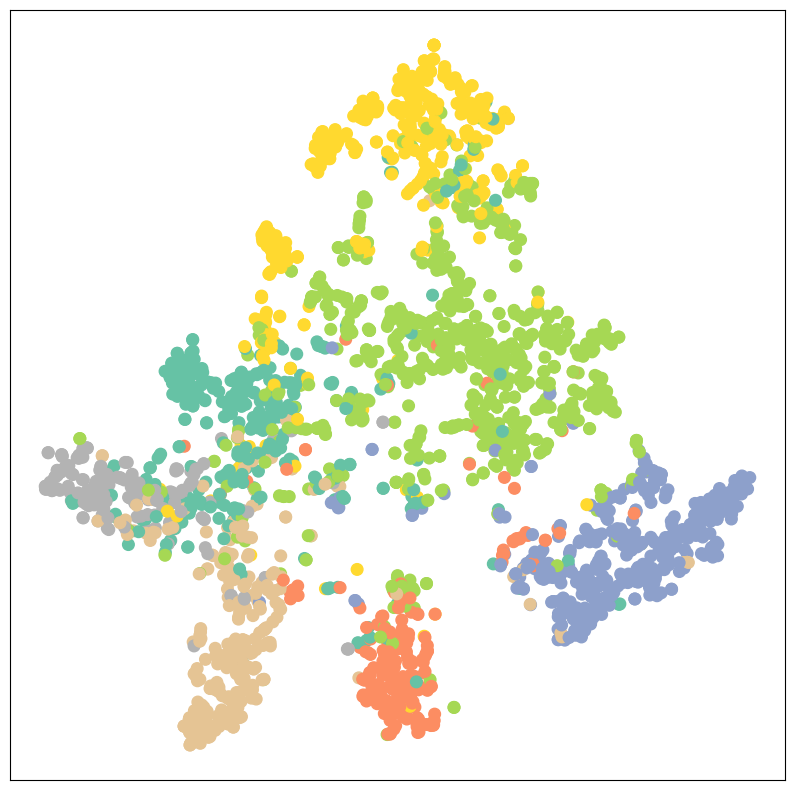

In [ ]:
model2.eval()
out = model2(data.x, data.edge_index)
visualize(out, color=data.y)

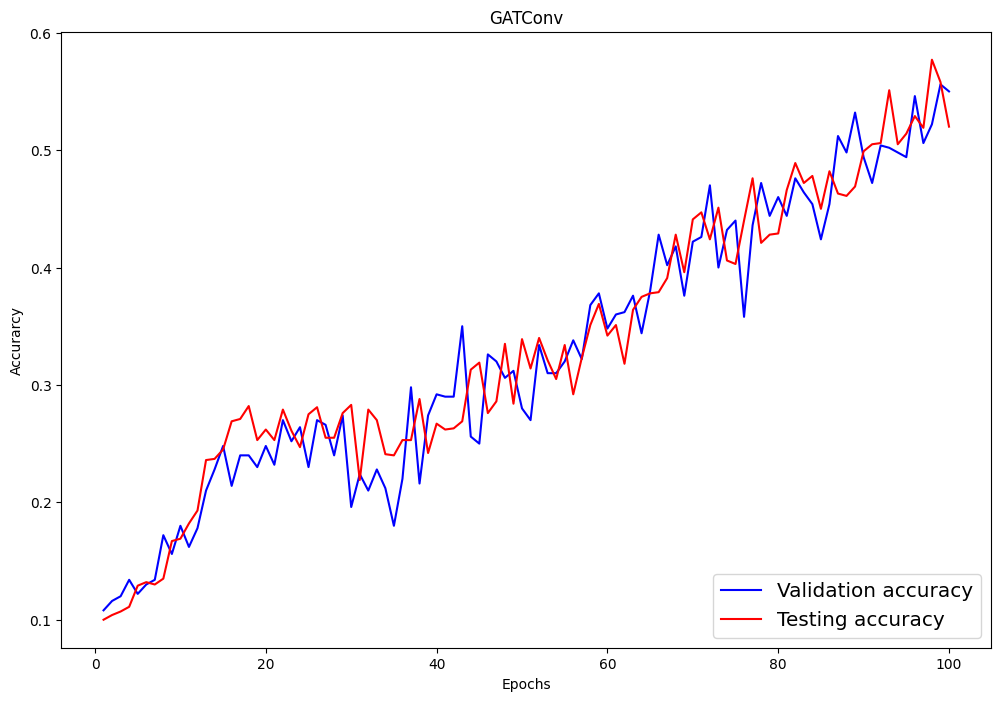

In [ ]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)j
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()